=== Model Performance ===
       Features                 Model          MAE       R2
       WAR only      LinearRegression 2.906596e-09 1.000000
       WAR only RandomForestRegressor 2.665031e-02 0.999990
Statcast top-10      LinearRegression 1.035486e+01 0.243012
Statcast top-10 RandomForestRegressor 1.031427e+01 0.205797
   Combined all      LinearRegression 3.060342e-09 1.000000
   Combined all RandomForestRegressor 7.319561e-02 0.999840

=== Combined RF Test Metrics ===
MAE = 0.073
R2  = 1.000


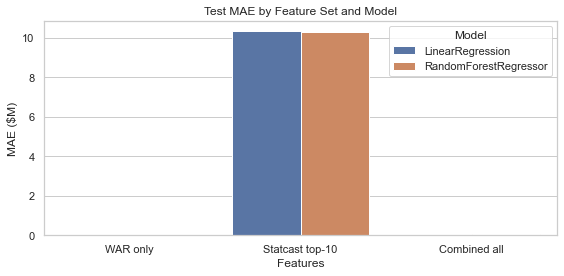

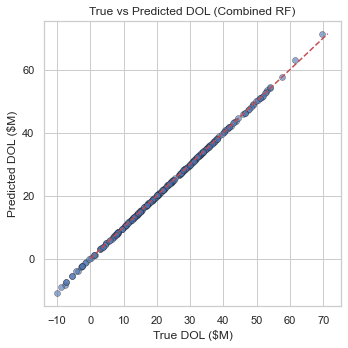

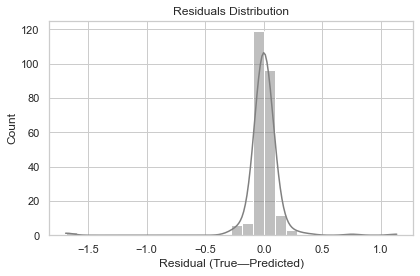

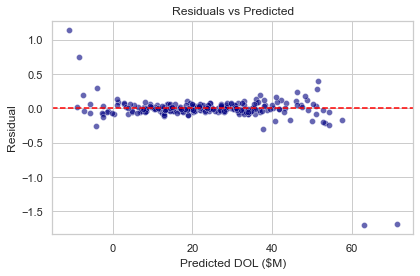

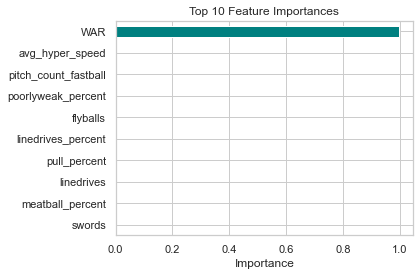

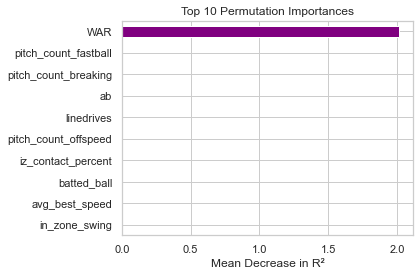

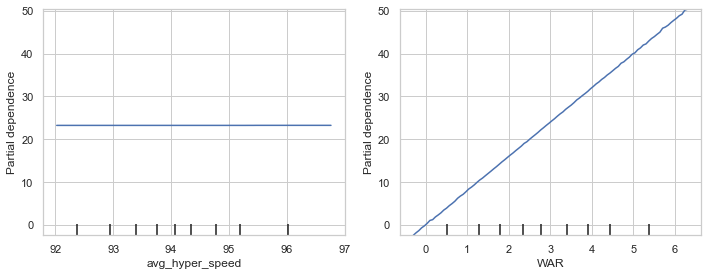

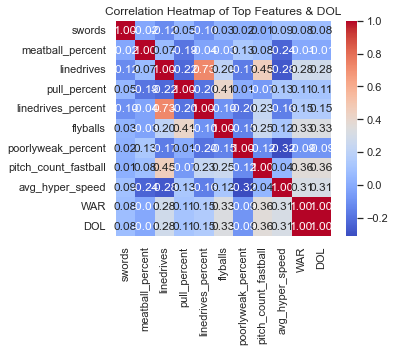

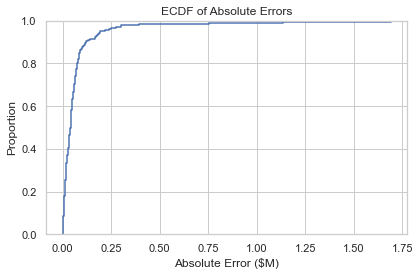

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error, r2_score


# 2) Load & merge
fg = pd.read_csv('fangraphs-leaderboards.csv')[['Season','MLBAMID','WAR','DOL']].rename(
    columns={'Season':'season','MLBAMID':'player_id'}
).dropna(subset=['player_id','WAR','DOL'])
st = pd.read_csv('stats (4).csv').dropna(subset=['player_id','season'])
df = fg.merge(st, on=['player_id','season'], how='inner')

# 3) Features & target
exclude = {'player_name','player_id','season','WAR','DOL'}
stat_feats = [c for c in df.columns if df[c].dtype in [np.float64, np.int64] and c not in exclude]
X_war  = df[['WAR']]
X_stat = df[stat_feats]
y      = df['DOL']

# 4) Impute
imp = SimpleImputer(strategy='mean')
X_stat_imp = pd.DataFrame(imp.fit_transform(X_stat), columns=stat_feats)
X_comb     = pd.concat([X_war.reset_index(drop=True), X_stat_imp], axis=1)

# 5) Top‐10 by correlation
corrs   = X_stat_imp.corrwith(y).abs().sort_values(ascending=False)
top10   = corrs.head(10).index.tolist()
X_stat10 = X_stat_imp[top10]

# 6) Evaluate feature‐set models
feature_sets = {
    'WAR only':       X_war,
    'Statcast top-10':X_stat10,
    'Combined all':   X_comb
}

results = []
for name, X_fs in feature_sets.items():
    X_tr, X_te, y_tr, y_te = train_test_split(X_fs, y, test_size=0.2, random_state=42)
    for Model in (LinearRegression, RandomForestRegressor):
        model = Model() if Model is LinearRegression else Model(random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)
        results.append({
            'Features': name,
            'Model': model.__class__.__name__,
            'MAE': mean_absolute_error(y_te, preds),
            'R2':  r2_score(y_te, preds)
        })

res_df = pd.DataFrame(results)
print("=== Model Performance ===")
print(res_df.to_string(index=False))

# 7) Detailed Combined RF metrics
X_tr, X_te, y_tr, y_te = train_test_split(X_comb, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_tr, y_tr)
preds = rf.predict(X_te)
print("\n=== Combined RF Test Metrics ===")
print(f"MAE = {mean_absolute_error(y_te, preds):.3f}")
print(f"R2  = {r2_score(y_te, preds):.3f}")

# 8) Plots
sns.set(style="whitegrid")

# 8a) MAE bar chart
plt.figure(figsize=(8,4))
sns.barplot(data=res_df, x='Features', y='MAE', hue='Model')
plt.title('Test MAE by Feature Set and Model')
plt.ylabel('MAE ($M)')
plt.tight_layout()
plt.show()

# 8b) True vs Predicted
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_te, y=preds, alpha=0.6, edgecolor='k')
mx = max(y_te.max(), preds.max())
plt.plot([0, mx], [0, mx], 'r--')
plt.title('True vs Predicted DOL (Combined RF)')
plt.xlabel('True DOL ($M)')
plt.ylabel('Predicted DOL ($M)')
plt.tight_layout()
plt.show()

# 8c) Residuals distribution
resid = y_te - preds
plt.figure(figsize=(6,4))
sns.histplot(resid, bins=30, kde=True, color='gray')
plt.title('Residuals Distribution')
plt.xlabel('Residual (True—Predicted)')
plt.tight_layout()
plt.show()

# 8d) Residuals vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=preds, y=resid, alpha=0.6, color='navy')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted DOL ($M)')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

# 8e) Feature importances
imps = pd.Series(rf.feature_importances_, index=X_comb.columns).sort_values()
plt.figure(figsize=(6,4))
imps[-10:].plot(kind='barh', color='teal')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 8f) Permutation importances
perm = permutation_importance(rf, X_te, y_te, n_repeats=10, random_state=42, n_jobs=-1)
pimps = pd.Series(perm.importances_mean, index=X_comb.columns).sort_values()
plt.figure(figsize=(6,4))
pimps[-10:].plot(kind='barh', color='purple')
plt.title('Top 10 Permutation Importances')
plt.xlabel('Mean Decrease in R²')
plt.tight_layout()
plt.show()

# 8g) Partial dependence (top 2)
top2 = imps[-2:].index.tolist()
fig, axs = plt.subplots(1, 2, figsize=(10,4))
PartialDependenceDisplay.from_estimator(rf, X_te, top2, feature_names=X_comb.columns, ax=axs)
plt.tight_layout()
plt.show()

# 8h) Correlation heatmap of top features + DOL
corr_feats = imps[-10:].index.tolist() + ['DOL']
corr_mat   = df[corr_feats].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_mat, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Top Features & DOL')
plt.tight_layout()
plt.show()

# 8i) ECDF of absolute errors
abs_err = np.abs(resid)
plt.figure(figsize=(6,4))
sns.ecdfplot(abs_err)
plt.title('ECDF of Absolute Errors')
plt.xlabel('Absolute Error ($M)')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()